In [29]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection as model_selection

In [30]:
data = pd.read_csv('master_model_data.csv', index_col=0)

In [31]:
data.head()

,DESYNPUF_ID,BENE_SEX_IDENT_CD,BENE_RACE_CD,SP_STATE_CODE,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,...,#Rx_mm,$Rx_mm,carrier_pmt_mm,carrier_number_claims_mm,office_visits_mm,office_visits_pmt_mm,CLM_ID_mm,TOTAL_PAYMENT_PERID_mm,total_pmt_mm,age_bucket
0,00000B48BCF4AD29,1,5,10,2,1,2,2,2,2,...,0.166667,7.000000,541.000000,4.700000,1.300000,181.333333,0.333333,90.000000,3338.0,4
1,0000525AB30E4DEF,1,1,31,2,2,2,2,2,2,...,3.966667,213.666667,432.000000,3.733333,0.833333,105.666667,0.966667,179.333333,1225.0,4
2,00009C897C3D8372,0,1,7,2,1,2,2,2,2,...,1.733333,138.000000,107.333333,1.600000,0.200000,7.333333,0.433333,85.333333,1534.0,3
3,0001168CE43BE51B,1,1,6,2,2,2,2,2,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3
4,0002E494BC87CE10,0,2,5,2,2,2,2,2,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4


In [32]:
working_data = data

In [33]:
working_data = working_data.drop_duplicates(['DESYNPUF_ID'])

In [34]:
#prevent data leakage
working_data = data.drop(['DESYNPUF_ID','CLM_ADMSN_DT', 'fst_admsn_dt', 'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP', 
                         'BENE_DEATH_DT', 'DEATH'], axis=1)

ValueError: labels ['CLM_ADMSN_DT' 'fst_admsn_dt' 'MEDREIMB_OP' 'BENRES_OP' 'PPPYMT_OP'
 'BENE_DEATH_DT' 'DEATH'] not contained in axis

Variable descriptions:

Sex_Ident: 1 = Male, 2= Female
Race: 1 = White, 2 = Black, 3 = Others, 4 = Hispanic
Binary variables: 1 = Yes, 2 = No 


/Users/ksenia/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


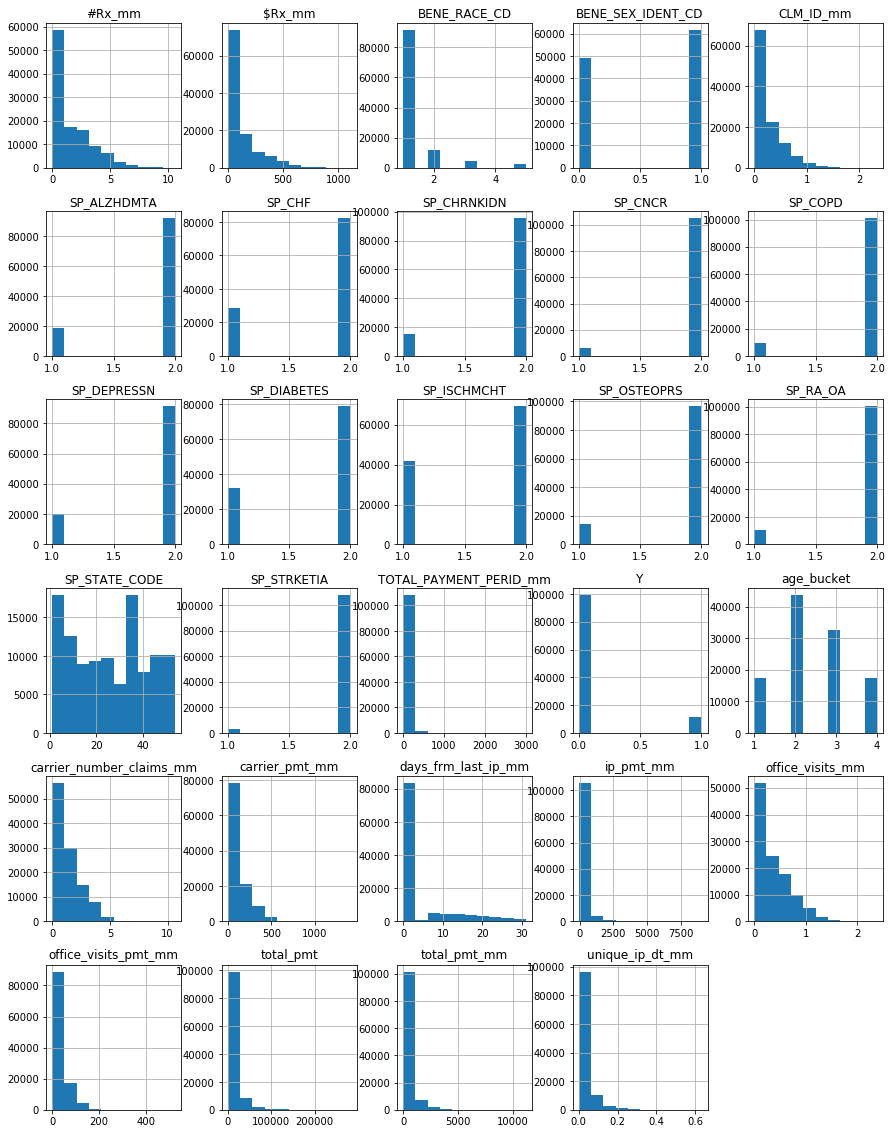

In [35]:
#Plot histograms of all features
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
working_data.hist(ax = ax)
plt.show()

In [36]:
c_mat = working_data.corr()
print(c_mat['Y'].sort_values(ascending=False))

Y                           1.000000
unique_ip_dt_mm             0.468749
carrier_number_claims_mm    0.207429
office_visits_mm            0.193575
carrier_pmt_mm              0.187030
office_visits_pmt_mm        0.163145
CLM_ID_mm                   0.155762
total_pmt_mm                0.120774
TOTAL_PAYMENT_PERID_mm      0.106097
$Rx_mm                      0.071102
#Rx_mm                      0.063415
ip_pmt_mm                   0.055512
total_pmt                   0.036107
age_bucket                  0.018927
BENE_SEX_IDENT_CD           0.010365
SP_STATE_CODE               0.001310
BENE_RACE_CD               -0.014207
days_frm_last_ip_mm        -0.041472
SP_OSTEOPRS                -0.094860
SP_RA_OA                   -0.096625
SP_CNCR                    -0.102463
SP_STRKETIA                -0.136256
SP_DEPRESSN                -0.146370
SP_ALZHDMTA                -0.163383
SP_CHF                     -0.218287
SP_ISCHMCHT                -0.220966
SP_DIABETES                -0.227962
S

Because our features show 2 for not having the disease, the correlations revealed a positive linear relationship between the patient having kidney disease and hospitalization (22%). Other strongest factors were diabetes (18%), ischemic heart disease (17%), and heart failure (16%). 

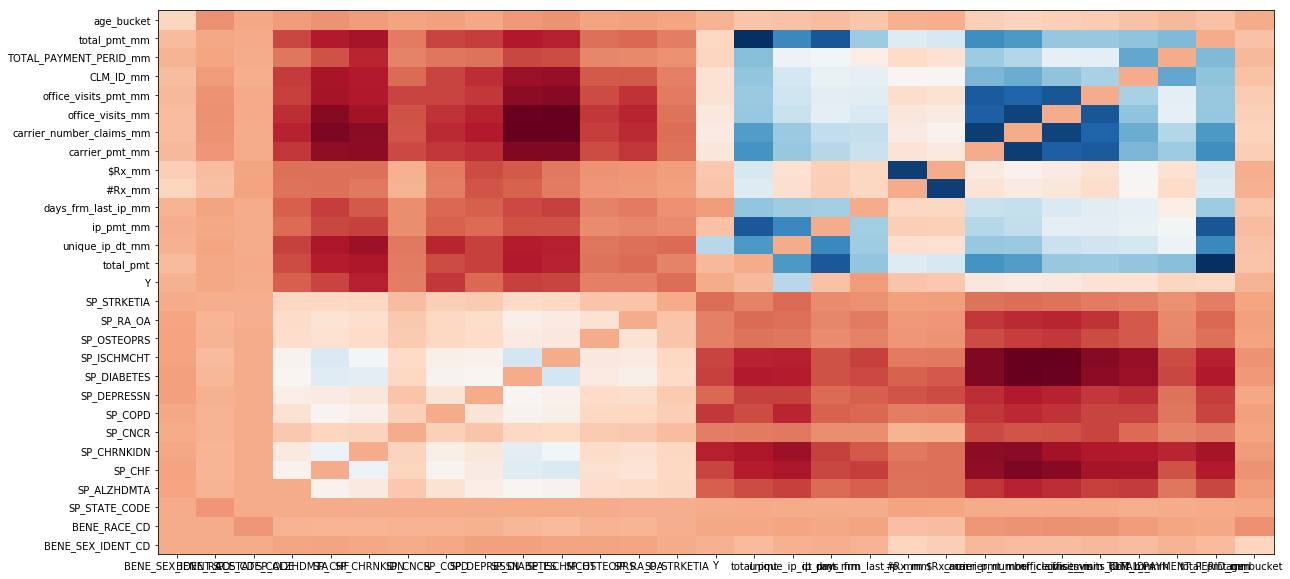

In [37]:
#Visualize correlations. Red signifies the strongest negative correlations

for i in range(c_mat.shape[0]):
    c_mat.iloc[i,i] = 0
 
    
fig, ax = plt.subplots(figsize = (20,10))
heatmap = ax.pcolor(c_mat, cmap=plt.cm.RdBu)

#Set the tick labels and center them
ax.set_xticks(np.arange(c_mat.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(c_mat.shape[1])+0.5, minor=False)
ax.set_xticklabels(c_mat.index.values, minor=False)
ax.set_yticklabels(c_mat.index.values, minor=False)

heatmap.set_label('Pearson Correlation')

plt.show()

In [39]:
working_data.drop('DESYNPUF_ID',axis=1, inplace = True)

In [40]:
#Normalize features

import sklearn.preprocessing as sk

labels = working_data.drop('Y', axis=1).columns
index = working_data.index

norm = pd.DataFrame(sk.scale(working_data.drop('Y', axis=1)), columns = labels, index = index)
norm['Y'] =  working_data['Y']

norm.describe()

,BENE_SEX_IDENT_CD,BENE_RACE_CD,SP_STATE_CODE,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,...,$Rx_mm,carrier_pmt_mm,carrier_number_claims_mm,office_visits_mm,office_visits_pmt_mm,CLM_ID_mm,TOTAL_PAYMENT_PERID_mm,total_pmt_mm,age_bucket,Y
count,1.110270e+05,1.110270e+05,1.110270e+05,1.110270e+05,1.110270e+05,1.110270e+05,1.110270e+05,1.110270e+05,1.110270e+05,1.110270e+05,...,1.110270e+05,1.110270e+05,1.110270e+05,1.110270e+05,1.110270e+05,1.110270e+05,1.110270e+05,1.110270e+05,1.110270e+05,111027.000000
mean,-1.530195e-16,3.121945e-15,8.880624e-17,-2.332261e-15,1.350041e-15,4.865664e-16,8.724506e-16,-4.627394e-16,-2.920801e-15,-4.140705e-16,...,-2.661812e-16,-7.401437e-17,-8.025258e-16,-7.069406e-16,-2.387589e-16,-8.876924e-17,-1.599862e-16,-3.841137e-17,2.491295e-17,0.103921
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,0.305159
min,-1.121882e+00,-3.768978e-01,-1.592782e+00,-2.225361e+00,-1.696346e+00,-2.491896e+00,-4.283229e+00,-3.200506e+00,-2.142279e+00,-1.559845e+00,...,-7.367657e-01,-8.792190e-01,-1.030911e+00,-1.037285e+00,-8.427218e-01,-8.521247e-01,-4.498493e-01,-7.194574e-01,-1.547998e+00,0.000000
25%,-1.121882e+00,-3.768978e-01,-9.484612e-01,4.493652e-01,-1.696346e+00,4.013009e-01,2.334687e-01,3.124506e-01,4.667927e-01,-1.559845e+00,...,-7.160915e-01,-8.108116e-01,-9.230791e-01,-9.385034e-01,-8.050936e-01,-8.521247e-01,-4.310262e-01,-5.769039e-01,-4.782060e-01,0.000000
50%,8.913589e-01,-3.768978e-01,-4.641175e-02,4.493652e-01,5.895025e-01,4.013009e-01,2.334687e-01,3.124506e-01,4.667927e-01,6.410893e-01,...,-4.783386e-01,-2.872321e-01,-1.952155e-01,-1.905842e-01,-3.206303e-01,-3.523153e-01,-2.969118e-01,-3.295317e-01,-4.782060e-01,0.000000
75%,8.913589e-01,-3.768978e-01,8.556377e-01,4.493652e-01,5.895025e-01,4.013009e-01,2.334687e-01,3.124506e-01,4.667927e-01,6.410893e-01,...,3.635591e-01,3.942106e-01,5.865640e-01,6.420051e-01,4.084163e-01,5.223513e-01,9.601988e-02,1.861765e-01,5.915861e-01,0.000000
max,8.913589e-01,4.933487e+00,1.822119e+00,4.493652e-01,5.895025e-01,4.013009e-01,2.334687e-01,3.124506e-01,4.667927e-01,6.410893e-01,...,6.921862e+00,1.022645e+01,7.567245e+00,6.018556e+00,1.398279e+01,7.894541e+00,2.080066e+01,1.800580e+01,1.661378e+00,1.000000


In [41]:
#Split dataset into testing and training

test, train = model_selection.train_test_split(norm)

train_Y = train.pop('Y')
train_X = train

test_Y = test.pop('Y')
test_X = test


In [42]:
#Base Rate: predicting negative all the time
share_non_target = norm[norm.Y == 0].shape[0]/norm.shape[0]

base_rate = share_non_target

print('Base rate of forecast represented by always predicting not being hospitalized is: ', str(base_rate))

Base rate of forecast represented by always predicting not being hospitalized is:  0.8960793320543652


In [43]:
#Let's test features with a decision tree

from sklearn import tree

#Create a Decision Tree instance
clf = tree.DecisionTreeClassifier(criterion='entropy')

#Train decision tree
clf.fit(train_X, train_Y)



DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [44]:
labels = working_data.columns[:-1]
labels

Index(['BENE_SEX_IDENT_CD', 'BENE_RACE_CD', 'SP_STATE_CODE', 'SP_ALZHDMTA',
       'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN',
       'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
       'Y', 'total_pmt', 'unique_ip_dt_mm', 'ip_pmt_mm', 'days_frm_last_ip_mm',
       '#Rx_mm', '$Rx_mm', 'carrier_pmt_mm', 'carrier_number_claims_mm',
       'office_visits_mm', 'office_visits_pmt_mm', 'CLM_ID_mm',
       'TOTAL_PAYMENT_PERID_mm', 'total_pmt_mm'],
      dtype='object')

[  0.00000000e+00   3.93513198e-04   5.50863929e-04   3.60428074e-04
   0.00000000e+00   2.04529211e-04   0.00000000e+00   4.66586427e-04
   5.96086936e-04   2.96969239e-04   0.00000000e+00   0.00000000e+00
   0.00000000e+00   4.46145731e-04   3.99830082e-02   6.74327149e-01
   1.98661466e-03   2.61565596e-01   3.97090503e-04   9.31998349e-04
   7.42923936e-04   1.18325814e-03   1.21907932e-03   1.87856814e-03
   2.40924647e-04   2.16034032e-03   9.74548209e-03   3.22843838e-04]


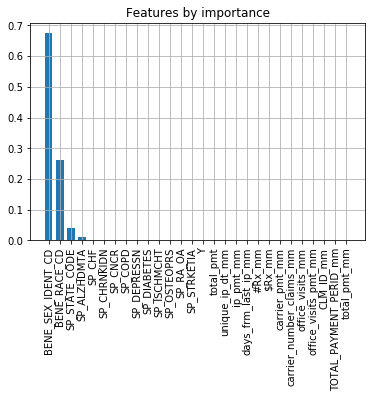

In [45]:
#Visualize feature importance
import matplotlib.pyplot as plt
%matplotlib inline

importances = clf.feature_importances_
#print(len(importances))

labels = working_data.columns[:-1]

assert(len(importances) == len(labels))

print(importances)

#Sort and order importances in descending order
importances.sort()
importances = importances[::-1]

N = len(importances)
xx = np.linspace(0, 1, N)
plt.bar(xx, importances, width=1/N/1.5)
plt.xticks(xx, labels, rotation='vertical')
plt.title('Features by importance')
plt.grid(True)

In [46]:
from sklearn import metrics

#Predicting train_df
fcst_train = clf.predict(train_X)

#Predicting test_df
fcst_test = clf.predict(test_X)

train_accuracy = clf.score(train_X, train_Y)
test_accuracy = clf.score(test_X, test_Y)

print('Train accuracy:',train_accuracy, '\nTest accuracy:', test_accuracy, '\nDifference:', 
     train_accuracy - test_accuracy)

Train accuracy: 1.0 
Test accuracy: 0.996613426204 
Difference: 0.00338657379608


In [47]:
#Tune the decision tree by testing hyperparameters
min_samples_split_values = np.linspace(200, 1000, 10, dtype = int)
min_samples_leaf_values = np.linspace(50, 200, 10, dtype = int)

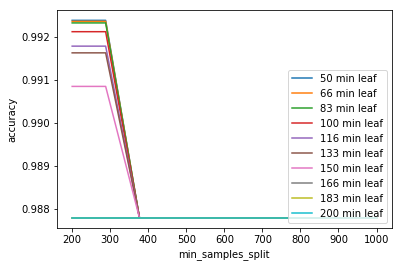

In [48]:
import matplotlib.pyplot as plt

for leaf in min_samples_leaf_values:
    accuracy = []
    
    for split in min_samples_split_values:
        
        clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split = split, min_samples_leaf = leaf)
        
        clf.fit(train_X, train_Y)
        
        fcst_tests = clf.predict(test_X)
        
        accuracy.append(metrics.accuracy_score(test_Y, fcst_tests))
 
    plt.plot(min_samples_split_values, accuracy, label = str(leaf) + ' min leaf')
    plt.xlabel('min_samples_split')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")

In [49]:
index_max_accuracy = accuracy.index(max(accuracy))

best_samples_split = min_samples_split_values[index_max_accuracy]
best_min_leaf = min_samples_leaf_values[index_max_accuracy]
best_accuracy = accuracy[index_max_accuracy]

print('Best Min Samples Split: ' + str(best_samples_split) + '\nBest Min Leaf: ' + str(best_min_leaf) 
      + '\nBest Accuracy: ' + str(best_accuracy))

Best Min Samples Split: 200
Best Min Leaf: 50
Best Accuracy: 0.987786717906


In [50]:
#We didn't beat the base rate
print('{0:.5f}'.format((base_rate - best_accuracy)))

-0.09171


In [51]:

#Making a decision tree and AUC to check feature importances
from sklearn.tree import DecisionTreeClassifier

#build a decision tree with max_depth = 20 using entropy
Y = train_Y
X = train_X

dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 20)
dt.fit(X, Y)

#Now use built in feature importance attribute to get MI of each feature and Y
feature_mi = dt.feature_importances_
#Add features and their importances to a dictionary
feature_mi_dict = dict(zip(X.columns.values, feature_mi))

In [52]:
#define a function to print ROC curves. 
#It should take in only arrays/lists of predictions and outcomes
from sklearn.metrics import roc_curve, auc

def plotUnivariateROC(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    #Student input code here
    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    #we are doing this as a special case because we are sending unfitted predictions
    #into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())

    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

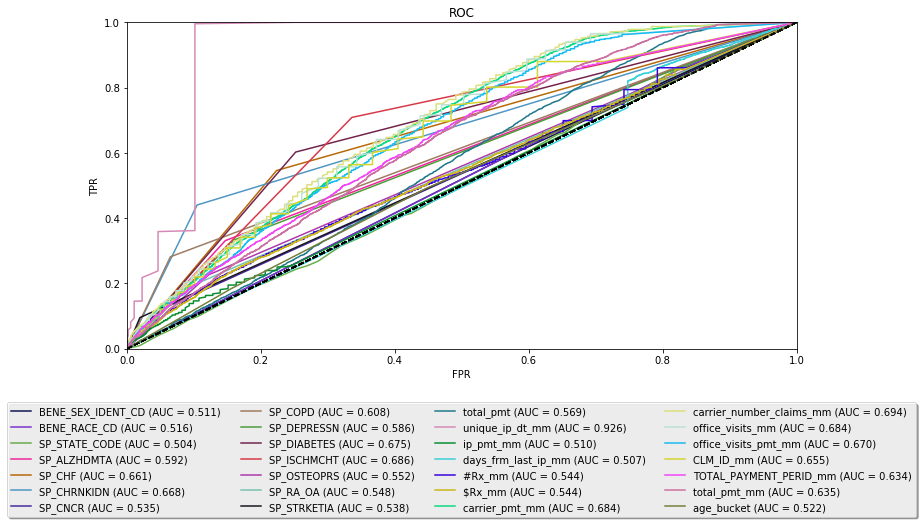

In [53]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

#Plot the univariate AUC on the training data. Store the AUC


#Student put code here
feature_auc_dict = {}
for col in X.columns:
    feature_auc_dict[col] = plotUnivariateROC(X[col], Y, col)


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

#### Conclusion

Conclusion: I analyzed demographics and health features for predicting hospitalization in the next 6 months. 
Correlation analysis revealed the strongest positive linear relationship between the patient having kidney disease and hospitalization (22%). Other strongest factors were diabetes (18%), ischemic heart disease (17%), and heart failure (16%). 

Decision tree analysis uncovered the strongest non-linear relationships with such factors as Age, Gender, and Race.

We defined the base rate to be the share of all patients who weren't hospitalized in the next 6 months. The base rate is very high at around 90%. The decision tree could not outperform the base rate implying we need a different model and probably more inputs. 

Next I will look into inputs varying over time such as hospital visits and medication intake in the 6 months prior to hospitalization.